In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from tqdm import tqdm
import torch.optim as optim
from torch.utils.data import Dataset, random_split
from torchvision import transforms
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error

In [2]:
root_path='/kaggle/input/mustard-dataset/mustard/content/drive/MyDrive/ACM grand challenge/Crops data/For_age_prediction'
crop='mustard'
csv_file='/kaggle/input/mustard-dataset/Ground Truth/Ground Truth/mustard_train.csv'
n_images=4
plant_input=3
days_input=50
batch_size = 8
seed=42
height, width = 224, 224
# Transformations for resizing and converting to tensor
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
class CropDataset(Dataset):
    def __init__(self, root_dir, csv_file, images_per_level, crop, plants, days,
                 levels=['L1', 'L2', 'L3', 'L4', 'L5'], transform=None):
        """
        Args:
            root_dir (str): Directory with all the images.
            csv_file (str): Path to the CSV file containing ground truth (filename, leaf_count, age).
            images_per_level (int): Number of images to select per level (should be factors of 24).
            crop (str): Crop type (e.g., "mustard").
            plants (int): Number of plants (e.g., 4).
            days (int): Number of days (e.g., 59).
            levels (list): List of levels (e.g., ['L1', 'L2', 'L3', 'L4', 'L5']).
            transform (callable, optional): Transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.csv_file = csv_file
        self.images_per_level = images_per_level
        self.crop = crop
        self.plants_num = plants
        self.max_days = days
        self.levels = levels
        self.transform = transform
        self.image_data = self._load_metadata()
        self.image_paths = self._load_image_paths()

    def _load_metadata(self):
        """Load CSV file into a pandas DataFrame and map filenames to leaf counts and ages."""
        df = pd.read_csv(self.csv_file)
        df["filename"] = df["filename"].astype(str)  # Ensure filenames are strings
        return df.set_index("filename")  # Use filename as the index for quick lookup

    def _select_angles(self):
        """
        Select angles dynamically for a given level.
        """
        images_needed = self.images_per_level
        selected_angles = [i for i in range(0, 360, int(360 / images_needed))]

        initial_angles = [i for i in range(15, selected_angles[1], 15)]
        multiple_selections = [selected_angles]

        for initial_angle in initial_angles:
            selection = [initial_angle]
            while len(selection) < images_needed:
                next_angle = (selection[-1] + int(360 / images_needed)) % 360
                if next_angle not in selection:
                    selection.append(next_angle)
            multiple_selections.append(selection)
        print(f"multiple_selections: {multiple_selections}")
        return multiple_selections

    def _load_image_paths(self):
        """
        Load image paths for all levels and plants based on the selection of angles.
        """
        image_paths = []
        multiple_selections = self._select_angles()

        for plant in range(1, self.plants_num + 1):
            plant_path = os.path.join(self.root_dir, crop, f"p{plant}")
            if not os.path.isdir(plant_path):
                print(f"Plant directory not found: {plant_path}")
                continue
            for day in range(1, self.max_days + 1):
                day_path = os.path.join(self.root_dir, crop, f"p{plant}", f"d{day}")
                if not os.path.isdir(day_path):
                    print(f"day directory not found: {day_path}")
                    continue
                for selected_angles in multiple_selections:
                    for level in self.levels:
                        level_path = os.path.join(self.root_dir,self.crop, f"p{plant}", f"d{day}", level)
                        level_image_paths = [
                            os.path.join(level_path, f"{self.crop}_p{plant}_d{day}_{level}_{angle}.png")
                            for angle in selected_angles
                        ]
                        filename = os.path.join(self.crop,f"p{plant}", f"d{day}", level,f"{self.crop}_p{plant}_d{day}_{level}_{selected_angles[0]}.png")
                        leaf_count = self.image_data.loc[filename, "leaf_count"]
                        # print(level_image_paths)
                        image_paths.append((level_image_paths, leaf_count,day))  # Append day number along with image paths

        print(f"Total samples loaded: {len(image_paths)}")
        # print(f"individual sample size: {len(image_paths[0][0])}")
        return image_paths


    def __len__(self):
        return len(self.image_paths)


    def __getitem__(self, idx):
        """
        Get a batch of images from the dataset corresponding to the angles selected.
        """
        images = []
        leaf_count = self.image_paths[idx][1]
        age = self.image_paths[idx][2]
        # print(leaf_count,age)
        all_images= self.image_paths[idx][0]
        # print("length of all images:", len(all_images))
        for img_path in all_images:  # Get the image paths for this sample
            if os.path.isfile(img_path):
                  level_image = Image.open(img_path)
                  if self.transform:
                      level_image = self.transform(level_image)
                  images.append(level_image)
            else:
                    print(f"Path is not a valid file: {img_path}")

        images = torch.cat(images, dim=0)

        return images, torch.tensor(leaf_count, dtype=torch.float32), torch.tensor(age, dtype=torch.float32)  # Return both images and the corresponding day as ground truth

dataset = CropDataset(root_dir=root_path,
                      csv_file=csv_file,
                      images_per_level=n_images,
                      crop=crop,
                      plants=plant_input,
                      days=days_input,
                      transform=transform)
# Split the dataset into training and validation sets
train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int(0.1 * len(dataset))  # 10% validation
test_size = int(0.2 * len(dataset)) # 20% test data
print(train_size,val_size, test_size)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


multiple_selections: [[0, 90, 180, 270], [15, 105, 195, 285], [30, 120, 210, 300], [45, 135, 225, 315], [60, 150, 240, 330], [75, 165, 255, 345]]
day directory not found: /kaggle/input/mustard-dataset/mustard/content/drive/MyDrive/ACM grand challenge/Crops data/For_age_prediction/mustard/p1/d12
day directory not found: /kaggle/input/mustard-dataset/mustard/content/drive/MyDrive/ACM grand challenge/Crops data/For_age_prediction/mustard/p1/d48
day directory not found: /kaggle/input/mustard-dataset/mustard/content/drive/MyDrive/ACM grand challenge/Crops data/For_age_prediction/mustard/p1/d49
day directory not found: /kaggle/input/mustard-dataset/mustard/content/drive/MyDrive/ACM grand challenge/Crops data/For_age_prediction/mustard/p1/d50
day directory not found: /kaggle/input/mustard-dataset/mustard/content/drive/MyDrive/ACM grand challenge/Crops data/For_age_prediction/mustard/p2/d12
day directory not found: /kaggle/input/mustard-dataset/mustard/content/drive/MyDrive/ACM grand challenge

In [3]:
class ImageEncoder(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()
        base = models.resnet18(pretrained=True)
        base.fc = nn.Identity()
        self.backbone = base
        self.projector = nn.Sequential(
            nn.Linear(512, embedding_dim),
            nn.ReLU(),
            nn.Linear(embedding_dim, embedding_dim)
        )

    def forward(self, x):
        # x shape: (B, CV, H, W)
        # Add to forward() for debugging
        B, CV, H, W = x.shape
        assert CV % 3 == 0, "Input channels must be divisible by 3 (RGB views)"
        V = CV // 3  # number of views
        x = x.view(B * V, 3, H, W)  # reshape into individual views
        feats = self.backbone(x)   # shape: [B*V, 512]
        feats = feats.view(B, V, -1).mean(dim=1)  # average over views
        # print(f"Input: {x.shape}, Views: {V}, Output: {feats.shape}")
        return self.projector(feats)  # shape: [B, embedding_dim]



In [4]:
class LeafRegressor(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()
        self.regressor = nn.Sequential(
            nn.Linear(embedding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, z):
        return self.regressor(z).squeeze(1)


### old code

Using device: cuda


Epoch 1
  Train Loss: 125.3674, MAE: 10.94
  Val   Loss: 133.3279, MAE: 11.27


Epoch 2
  Train Loss: 3.9932, MAE: 1.46
  Val   Loss: 3.9592, MAE: 1.47


Epoch 3
  Train Loss: 0.5488, MAE: 0.63
  Val   Loss: 0.6309, MAE: 0.67


Epoch 4
  Train Loss: 0.3646, MAE: 0.47
  Val   Loss: 0.7268, MAE: 0.63


Epoch 5
  Train Loss: 2.0827, MAE: 1.20
  Val   Loss: 2.4053, MAE: 1.19


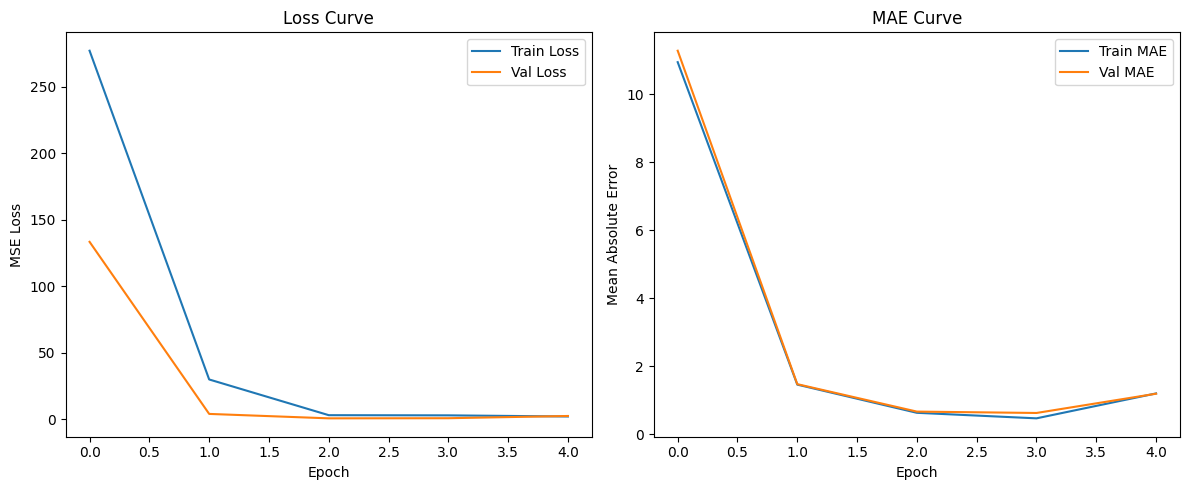

In [66]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Move models to device
encoder = ImageEncoder().to(device)
regressor = LeafRegressor().to(device)

# Optimizer
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(regressor.parameters()), lr=1e-4)

# DataLoaders with multiple workers for speed
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)

# Tracking metrics
train_losses, val_losses = [], []
train_maes, val_maes = [], []

# Evaluation helper
def evaluate(encoder, regressor, dataloader, device):
    encoder.eval()
    regressor.eval()
    total_loss = 0.0
    total_mae = 0.0
    count = 0

    criterion = nn.MSELoss()

    with torch.no_grad():
        for images, labels, _ in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            embeddings = encoder(images)
            preds = regressor(embeddings).squeeze()

            loss = criterion(preds, labels)
            mae = torch.abs(preds - labels).sum().item()

            total_loss += loss.item() * images.size(0)
            total_mae += mae
            count += images.size(0)

    return total_loss / count, total_mae / count

# Training loop
for epoch in range(5):  
    encoder.train()
    regressor.train()
    #print("just after regressor.train()")
    running_loss = 0.0
    criterion = nn.MSELoss()

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)
    for images, labels, _ in loop:
        images = images.to(device)
        labels = labels.to(device)
        #print("just after labels = labels.to")

        optimizer.zero_grad()
        embeddings = encoder(images)
        preds = regressor(embeddings).squeeze()

        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Evaluate both sets
    train_loss, train_mae = evaluate(encoder, regressor, train_loader, device)
    val_loss, val_mae = evaluate(encoder, regressor, val_loader, device)

    train_maes.append(train_mae)
    val_losses.append(val_loss)
    val_maes.append(val_mae)

    print(f"Epoch {epoch+1}")
    print(f"  Train Loss: {train_loss:.4f}, MAE: {train_mae:.2f}")
    print(f"  Val   Loss: {val_loss:.4f}, MAE: {val_mae:.2f}")

# Plot curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_maes, label='Train MAE')
plt.plot(val_maes, label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('MAE Curve')
plt.legend()

plt.tight_layout()
plt.show()




In [70]:
torch.save({
    'encoder_state_dict': encoder.state_dict(),
    'regressor_state_dict': regressor.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': 1,  # Update if needed
}, 'checkpoint_epoch_1.pt')


In [5]:
from sklearn.metrics import mean_squared_error

def evaluate(encoder, regressor, dataloader, device):
    encoder.eval()
    regressor.eval()
    total_loss = 0.0
    total_mae = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels, _ in dataloader:
            images, labels = images.to(device), labels.to(device)

            embeddings = encoder(images)
            preds = regressor(embeddings).squeeze()

            loss = criterion(preds, labels)
            mae = torch.abs(preds - labels).sum().item()

            total_loss += loss.item() * images.size(0)
            total_mae += mae
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader.dataset)
    avg_mae = total_mae / len(dataloader.dataset)
    rmse = mean_squared_error(all_labels, all_preds, squared=False)  # RMSE
    r2 = r2_score(all_labels, all_preds)

    return avg_loss, avg_mae, rmse, r2


In [6]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define loss
criterion = nn.MSELoss()

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Move models to device
encoder = ImageEncoder().to(device)
regressor = LeafRegressor().to(device)

# Debug: Check model device
print("Encoder on:", next(encoder.parameters()).device)
print("Regressor on:", next(regressor.parameters()).device)

# Optimizer
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(regressor.parameters()), lr=1e-4)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=24, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=24, shuffle=False, num_workers=4)

# Initialize metric history
train_losses, val_losses = [], []
train_maes, val_maes = [], []
train_rmses, val_rmses = [], []
train_r2s, val_r2s = [], []

# Evaluation function
def evaluate(encoder, regressor, dataloader, device):
    encoder.eval()
    regressor.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels, _ in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Debug: Show device
            # if torch.cuda.is_available():
            #     print("[Eval] Image device:", images.device)
            #     print("[Eval] Label device:", labels.device)

            embeddings = encoder(images)
            preds = regressor(embeddings).squeeze()

            loss = criterion(preds, labels)
            total_loss += loss.item() * images.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader.dataset)
    mae = np.mean(np.abs(np.array(all_preds) - np.array(all_labels)))
    rmse = np.sqrt(mean_squared_error(all_labels, all_preds))
    r2 = r2_score(all_labels, all_preds)

    return avg_loss, mae, rmse, r2

# Training loop
for epoch in range(5):
    encoder.train()
    regressor.train()
    running_loss = 0.0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)
    for images, labels, _ in loop:
        images, labels = images.to(device), labels.to(device)

        # Debug: Check image and label devices
        #if torch.cuda.is_available() and epoch == 0 and loop.n == 0:
            # print("[Train] First batch - Image device:", images.device)
            # print("[Train] First batch - Label device:", labels.device)

        optimizer.zero_grad()
        embeddings = encoder(images)
        preds = regressor(embeddings).squeeze()

        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Evaluate both sets
    train_loss, train_mae, train_rmse, train_r2 = evaluate(encoder, regressor, train_loader, device)
    val_loss, val_mae, val_rmse, val_r2 = evaluate(encoder, regressor, val_loader, device)

    train_maes.append(train_mae)
    train_rmses.append(train_rmse)
    train_r2s.append(train_r2)

    val_losses.append(val_loss)
    val_maes.append(val_mae)
    val_rmses.append(val_rmse)
    val_r2s.append(val_r2)

    print(f"\nEpoch {epoch+1}")
    print(f"  Train - Loss: {train_loss:.4f}, MAE: {train_mae:.2f}, RMSE: {train_rmse:.2f}, R²: {train_r2:.4f}")
    print(f"  Val   - Loss: {val_loss:.4f}, MAE: {val_mae:.2f}, RMSE: {val_rmse:.2f}, R²: {val_r2:.4f}")

    # Save model
    torch.save(encoder.state_dict(), f"encoder_epoch_{epoch+1}.pth")
    torch.save(regressor.state_dict(), f"regressor_epoch_{epoch+1}.pth")


Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 187MB/s]


Encoder on: cuda:0
Regressor on: cuda:0



Epoch 1
  Train - Loss: 7.1425, MAE: 2.05, RMSE: 2.67, R²: 0.8737
  Val   - Loss: 8.4899, MAE: 2.16, RMSE: 2.91, R²: 0.8479



Epoch 2
  Train - Loss: 2.6456, MAE: 1.13, RMSE: 1.63, R²: 0.9532
  Val   - Loss: 2.5251, MAE: 1.13, RMSE: 1.59, R²: 0.9547



Epoch 3
  Train - Loss: 3.5540, MAE: 1.61, RMSE: 1.89, R²: 0.9371
  Val   - Loss: 3.7577, MAE: 1.62, RMSE: 1.94, R²: 0.9327



Epoch 4
  Train - Loss: 1.5647, MAE: 0.95, RMSE: 1.25, R²: 0.9723
  Val   - Loss: 1.9013, MAE: 1.08, RMSE: 1.38, R²: 0.9659



Epoch 5
  Train - Loss: 0.8579, MAE: 0.69, RMSE: 0.93, R²: 0.9848
  Val   - Loss: 1.0600, MAE: 0.80, RMSE: 1.03, R²: 0.9810


In [ ]:
import torch
torch.save(encoder.state_dict(), f"encoder_epoch_{epoch+1}.pth")
torch.save(regressor.state_dict(), f"regressor_epoch_{epoch+1}.pth")

In [24]:
encoder = ImageEncoder().to(device)
regressor = LeafRegressor().to(device)

# Load trained weights
encoder.load_state_dict(torch.load("encoder_epoch_5.pth"))
regressor.load_state_dict(torch.load("regressor_epoch_5.pth"))

encoder.eval()
regressor.eval()

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)
test_loss, test_mae, test_rmse, test_r2 = evaluate(encoder, regressor, test_loader, device)
print(f"Test Loss: {test_loss:.4f}, MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}, R²: {test_r2:.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_31/2258399475.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detail

Test Loss: 41.8305, MAE: 5.32, RMSE: 6.47, R²: -2.3412


In [29]:
from torch.utils.data import random_split, DataLoader

# Define how much of the train_dataset you want to use for testing
test_portion = 0.2  # 20%
test_size = int(test_portion * len(train_dataset))
remaining_size = len(train_dataset) - test_size

# Split the train_dataset into a small test set and a remaining set
test_subset, _ = random_split(train_dataset, [test_size, remaining_size])

# Create DataLoader for this test portion
test_loader = DataLoader(test_subset, batch_size=8, shuffle=False, num_workers=0)

# Load model
encoder = ImageEncoder().to(device)
regressor = LeafRegressor().to(device)
encoder.load_state_dict(torch.load("encoder_epoch_5.pth"))
regressor.load_state_dict(torch.load("regressor_epoch_5.pth"))
encoder.eval()
regressor.eval()

# Evaluate
test_loss, test_mae, test_rmse, test_r2 = evaluate(encoder, regressor, test_loader, device)
print(f"Test on 20% of training data:\nLoss: {test_loss:.4f}, MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}, R²: {test_r2:.4f}")


/tmp/ipykernel_31/2595011248.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load("encoder_epoch_5.pth"))
/tmp/ipykernel_31/2595011248.py:

Test on 20% of training data:
Loss: 1.0323, MAE: 0.75, RMSE: 1.02, R²: 0.9842


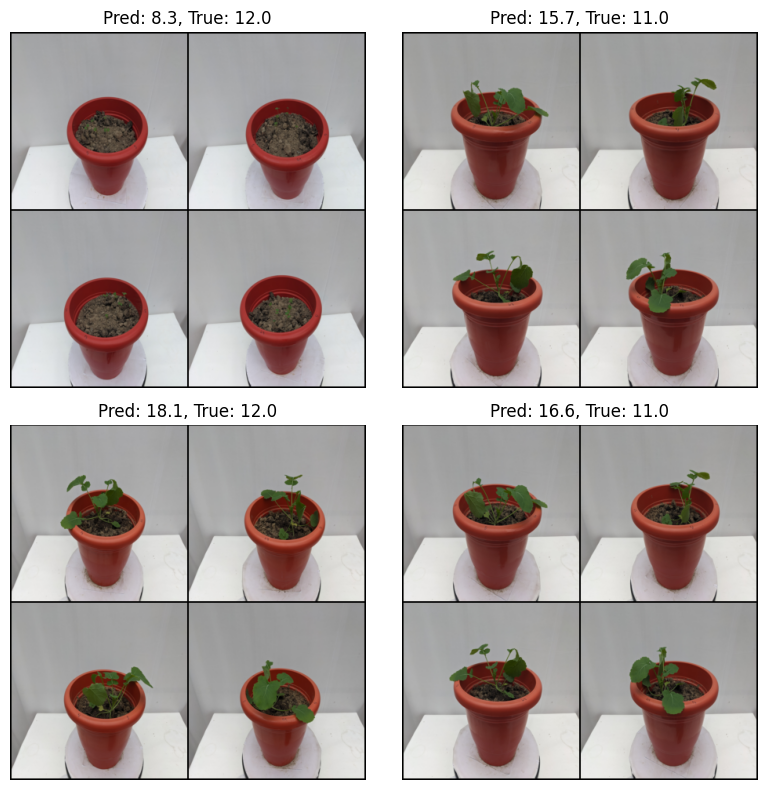

In [33]:
import torch
import matplotlib.pyplot as plt
import random
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

# Set to eval mode
encoder.eval()
regressor.eval()

# Pick 4 random samples from dataset
samples = random.sample(range(len(dataset)), 4)

fig, axs = plt.subplots(2, 2, figsize=(8, 8))

for i, idx in enumerate(samples):
    # image_tensor, true_age, _ = dataset[idx]  # image_tensor: [3*4, H, W]
    image_tensor, true_age, _ = dataset[idx]
    input_tensor = image_tensor.unsqueeze(0).to(device)  # [1, 12, H, W]

    # Predict
    with torch.no_grad():
        emb = encoder(input_tensor)
        pred_age = regressor(emb).item()

    # Show the 4 views
    axs[i // 2, i % 2].set_title(f"Pred: {pred_age:.1f}, True: {true_age:.1f}")
    axs[i // 2, i % 2].axis('off')

    # Reshape image_tensor into 4 views (4, 3, H, W)
    views = image_tensor.view(4, 3, 224, 224)  # [4, 3, H, W]
    
    # Use make_grid to combine images in a grid
    grid = make_grid(views, nrow=2)  # 2 images per row

    # Display the grid image
    axs[i // 2, i % 2].imshow(grid.permute(1, 2, 0).cpu().numpy())

plt.tight_layout()
plt.show()


Pred: 16.3 leaves
True: 11.0 leaves
Pred: 28.7 leaves
True: 13.0 leaves
Pred: 13.2 leaves
True: 12.0 leaves
Pred: 14.9 leaves
True: 12.0 leaves


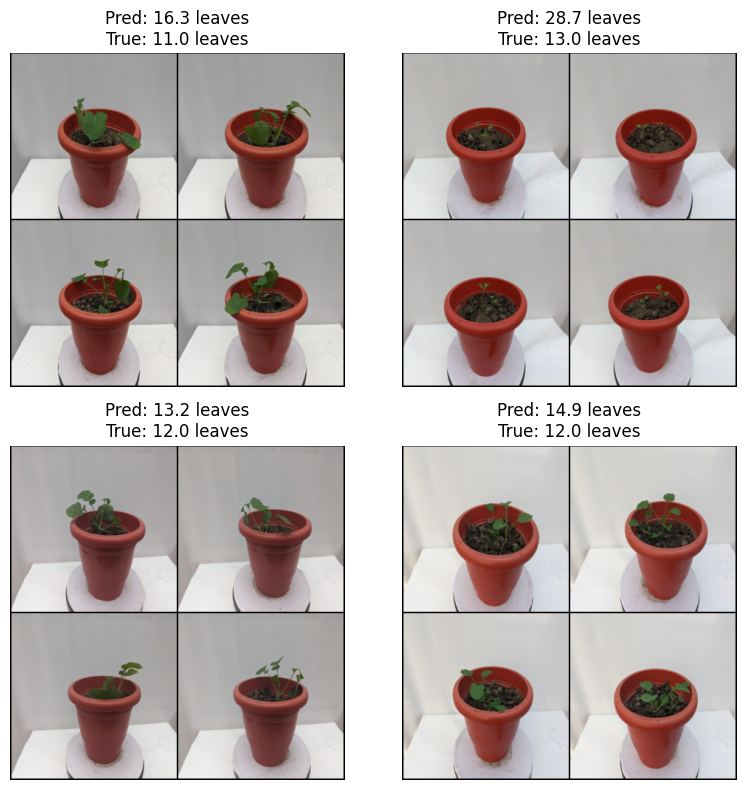

In [32]:
import torch
import matplotlib.pyplot as plt
import random
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

# Set to eval mode
encoder.eval()
regressor.eval()

# Pick 4 random samples from dataset
samples = random.sample(range(len(test_dataset)), 4)

fig, axs = plt.subplots(2, 2, figsize=(8, 8))

for i, idx in enumerate(samples):
    # image_tensor, true_age, _ = dataset[idx]  # image_tensor: [3*4, H, W]
    image_tensor, true_age, _ = dataset[idx]
    input_tensor = image_tensor.unsqueeze(0).to(device)  # [1, 12, H, W]

    # Predict
    with torch.no_grad():
        emb = encoder(input_tensor)
        pred_age = regressor(emb).item()

    # Show the 4 views
    axs[i // 2, i % 2].set_title(f"Pred: {pred_age:.1f} leaves\nTrue: {true_age:.1f} leaves", fontsize=12)
    axs[i // 2, i % 2].axis('off')
    print(f"Pred: {pred_age:.1f} leaves\nTrue: {true_age:.1f} leaves")

    # Reshape image_tensor into 4 views (4, 3, H, W)
    views = image_tensor.view(4, 3, 224, 224)  # [4, 3, H, W]
    
    # Use make_grid to combine images in a grid
    grid = make_grid(views, nrow=2)  # 2 images per row

    # Display the grid image
    axs[i // 2, i % 2].imshow(grid.permute(1, 2, 0).cpu().numpy())

plt.tight_layout()
plt.show()


In [87]:
def temporal_contrastive_loss(z1, z2, age1, age2, margin=1.0):
    # Normalize embeddings
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)

    # Cosine distance (1 - similarity)
    cos_dist = 1 - (z1 * z2).sum(dim=1)

    # Age difference normalized
    age_diff = torch.abs(age1 - age2).float()
    age_diff = age_diff / age_diff.max()

    # Contrastive loss (pull together if close in age, push if far)
    loss = torch.mean(age_diff * cos_dist + (1 - age_diff) * F.relu(margin - cos_dist))
    return loss


In [90]:
def train_epoch(encoder, regressor, loader, optimizer, device, alpha=0.1):
    encoder.train()
    regressor.train()
    total_loss, total_contrast, total_regress = 0.0, 0.0, 0.0

    for images, leaf_counts, ages in tqdm(loader):
        images, leaf_counts, ages = images.to(device), leaf_counts.to(device), ages.to(device)

        z = encoder(images)
        z1, z2 = z[:-1], z[1:]
        age1, age2 = ages[:-1], ages[1:]
        leaf1, leaf2 = leaf_counts[:-1], leaf_counts[1:]

        loss_contrast = temporal_contrastive_loss(z1, z2, age1, age2)
        loss_regress = F.mse_loss(regressor(z), leaf_counts)
        loss = loss_contrast + alpha * loss_regress

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_contrast += loss_contrast.item()
        total_regress += loss_regress.item()

    num_batches = len(loader)
    return (total_loss / num_batches, total_contrast / num_batches, total_regress / num_batches)


100%|██████████| 54/54 [03:21<00:00,  3.74s/it]


Epoch 1 | Total: 27.4376 | Contrastive: 0.5055 | Regression: 269.3214


100%|██████████| 54/54 [03:21<00:00,  3.74s/it]


Epoch 2 | Total: 3.3135 | Contrastive: 0.4809 | Regression: 28.3257


100%|██████████| 54/54 [03:21<00:00,  3.74s/it]


Epoch 3 | Total: 0.7008 | Contrastive: 0.4940 | Regression: 2.0678


100%|██████████| 54/54 [03:21<00:00,  3.74s/it]


Epoch 4 | Total: 0.7016 | Contrastive: 0.5016 | Regression: 1.9995


100%|██████████| 54/54 [03:21<00:00,  3.72s/it]


Epoch 5 | Total: 0.6455 | Contrastive: 0.5159 | Regression: 1.2963


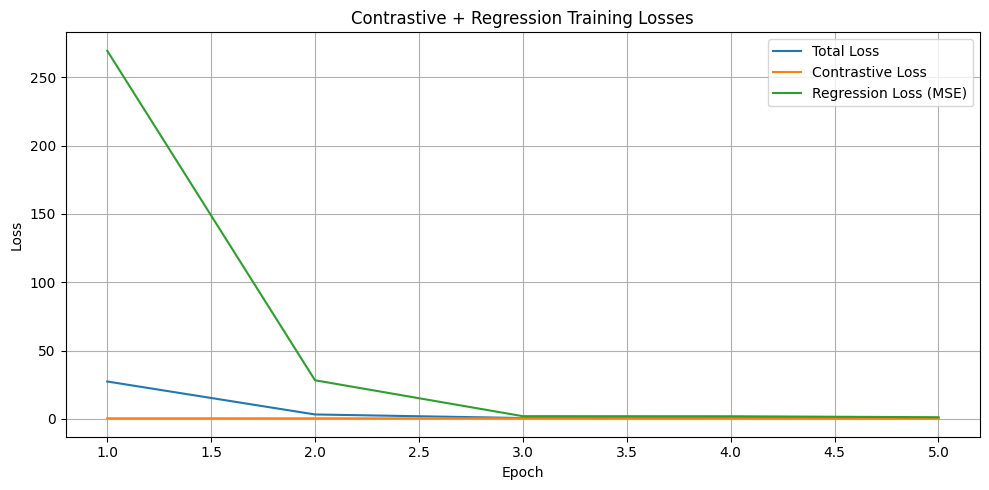

In [91]:
import matplotlib.pyplot as plt

# Init model + optimizer
cont_encoder = ImageEncoder().to(device)
cont_regressor = LeafRegressor().to(device)
optimizer = torch.optim.Adam(list(cont_encoder.parameters()) + list(cont_regressor.parameters()), lr=1e-4)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Track metrics
total_losses = []
contrastive_losses = []
regression_losses = []

# Training loop
for epoch in range(5):
    total, contrast, regress = train_epoch(cont_encoder, cont_regressor, train_loader, optimizer, device, alpha=0.1)
    total_losses.append(total)
    contrastive_losses.append(contrast)
    regression_losses.append(regress)

    print(f"Epoch {epoch+1} | Total: {total:.4f} | Contrastive: {contrast:.4f} | Regression: {regress:.4f}")

    # Save models
    torch.save(cont_encoder.state_dict(), f"contrastive_encoder_epoch_{epoch+1}.pth")
    torch.save(cont_regressor.state_dict(), f"contrastive_regressor_epoch_{epoch+1}.pth")

# 📊 Plot after training
epochs = range(1, len(total_losses) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, total_losses, label='Total Loss')
plt.plot(epochs, contrastive_losses, label='Contrastive Loss')
plt.plot(epochs, regression_losses, label='Regression Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Contrastive + Regression Training Losses')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("contrastive_training_loss.png")
plt.show()


In [ ]:
import torch
import matplotlib.pyplot as plt
import random
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

# Set to eval mode
encoder.eval()
regressor.eval()

# Pick 4 random samples from dataset
samples = random.sample(range(len(test_dataset)), 4)

fig, axs = plt.subplots(2, 2, figsize=(8, 8))

for i, idx in enumerate(samples):
    # image_tensor, true_age, _ = dataset[idx]  # image_tensor: [3*4, H, W]
    image_tensor, true_age, _ = dataset[idx]
    input_tensor = image_tensor.unsqueeze(0).to(device)  # [1, 12, H, W]

    # Predict
    with torch.no_grad():
        emb = encoder(input_tensor)
        pred_age = regressor(emb).item()

    # Show the 4 views
    axs[i // 2, i % 2].set_title(f"Pred: {pred_age:.1f} leaves\nTrue: {true_age:.1f} leaves", fontsize=12)
    axs[i // 2, i % 2].axis('off')
    print(f"Pred: {pred_age:.1f} leaves\nTrue: {true_age:.1f} leaves")

    # Reshape image_tensor into 4 views (4, 3, H, W)
    views = image_tensor.view(4, 3, 224, 224)  # [4, 3, H, W]
    
    # Use make_grid to combine images in a grid
    grid = make_grid(views, nrow=2)  # 2 images per row

    # Display the grid image
    axs[i // 2, i % 2].imshow(grid.permute(1, 2, 0).cpu().numpy())

plt.tight_layout()
plt.show()


In [92]:
cont_encoder = ImageEncoder().to(device)
cont_regressor = LeafRegressor().to(device)

# Load trained weights
cont_encoder.load_state_dict(torch.load("contrastive_encoder_epoch_5.pth"))
cont_regressor.load_state_dict(torch.load("contrastive_regressor_epoch_5.pth"))

cont_encoder.eval()
cont_regressor.eval()

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)
test_loss, test_mae, test_r2 = evaluate(cont_encoder, cont_regressor, test_loader, device)
print(f"Test Loss: {test_loss:.4f}, MAE: {test_mae:.2f}, R²: {test_r2:.4f}")

/tmp/ipykernel_31/1898962841.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cont_encoder.load_state_dict(torch.load("contrastive_encoder_epoch_5.pth"))
/tmp/ipykernel_3

Test Loss: 81.0297, MAE: 7.93, R²: -19.8325


Pred: 23.0 leaves
True: 21.0 leaves
Pred: 25.5 leaves
True: 22.0 leaves
Pred: 17.4 leaves
True: 22.0 leaves
Pred: 25.4 leaves
True: 22.0 leaves


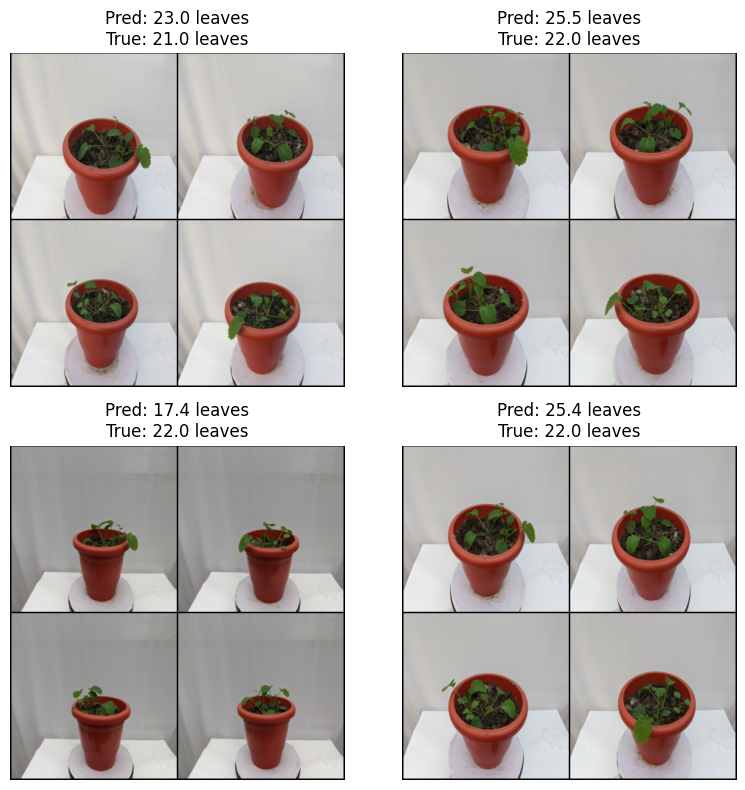

In [94]:
import torch
import matplotlib.pyplot as plt
import random
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

# Set to eval mode
cont_encoder.eval()
cont_regressor.eval()

# Pick 4 random samples from dataset
samples = random.sample(range(len(test_dataset)), 4)

fig, axs = plt.subplots(2, 2, figsize=(8, 8))

for i, idx in enumerate(samples):
    # image_tensor, true_age, _ = dataset[idx]  # image_tensor: [3*4, H, W]
    image_tensor, true_age, _ = dataset[idx]
    input_tensor = image_tensor.unsqueeze(0).to(device)  # [1, 12, H, W]

    # Predict
    with torch.no_grad():
        emb = cont_encoder(input_tensor)
        pred_age = cont_regressor(emb).item()

    # Show the 4 views
    axs[i // 2, i % 2].set_title(f"Pred: {pred_age:.1f} leaves\nTrue: {true_age:.1f} leaves", fontsize=12)
    axs[i // 2, i % 2].axis('off')
    print(f"Pred: {pred_age:.1f} leaves\nTrue: {true_age:.1f} leaves")

    # Reshape image_tensor into 4 views (4, 3, H, W)
    views = image_tensor.view(4, 3, 224, 224)  # [4, 3, H, W]
    
    # Use make_grid to combine images in a grid
    grid = make_grid(views, nrow=2)  # 2 images per row

    # Display the grid image
    axs[i // 2, i % 2].imshow(grid.permute(1, 2, 0).cpu().numpy())

plt.tight_layout()
plt.show()
